# Polymer Relaxation

This notebook is for relaxing an initialized system of randomly placed polymer chains. This is accomplished by slowly ramping up a soft potential [DPD](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.dpd) such that the repulsion between monomers matches that of a WCA repulsion between monomers. The system is then switched over to the [WCA potential](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.lj). Ramping from DPD to WCA is facilitated by a harmonic bonding potential to decrease the stiffness of the system. After switching to a WCA potential, the [harmonic bond potential](https://hoomd-blue.readthedocs.io/en/stable/module-md-bond.html#hoomd.md.bond.harmonic) is converted to a [FENE bond](https://hoomd-blue.readthedocs.io/en/stable/module-md-bond.html#hoomd.md.bond.fene) to finally obtain the Kremer-Grest bead-spring chain model. 

Many of the values used for this relaxation are dependent on the density, equilibrium bond length, and amount of overlap from the initialization of your polymer system. You will likely have to tune parameters such as the slope of the DPD potential, the FENE bond length $r_0$, and the particle radius in your FENE potential. 

In [1]:
from hoomd import *
from hoomd import md
import numpy as np

## Initialize System

First we initialize hoomd from a gsd file created using the Initialization - Polymer hoomd example and set up our system parameters along with the WCA potential parameters. 

We set $r_{cut}=2^{\frac{1}{6}}\sigma$, with $\sigma$ the monomer diameter, and scale the potential up by the addition of $\epsilon$ to yield a WCA potential from the following Lennard-Jones potential. 

\begin{eqnarray*}
        V_{\mathrm{LJ}}(r)  = & 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} -
                          \left( \frac{\sigma}{r} \right)^{6} \right]+\epsilon & r < r_{\mathrm{cut}} \\
                            = & 0 & r \ge r_{\mathrm{cut}} \\
        \end{eqnarray*}

In [2]:
# Initialize context
context.initialize("--mode=cpu");
system = init.read_gsd('init.gsd')

# Cell list
nl = md.nlist.cell();

# Get box size
Lx = system.box.Lx;

# Temperature
T_run = 1.0

# Define time steps for running
n_init = 1E4 # Initialization time steps
n_ramp = 1E4 # Number of DPD potential values to ramp over 

# Define monomer-monomer potential
eps_lj = 1.0
sigma = 1.0 # Particle diameter 
rcut = 2.0**(1.0/6.0)*sigma

HOOMD-blue 2.8.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 10/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1000 particles


## Find Potential Scaling

As mentioned above, we now need to find a value for a soft DPD potential which matches the monomer repulsion from the WCA potential so that we can slowly ramp our polymer system to the correct potential. This requires making a discerning choice for the maximum value of the muliplicitave prefactor $A$ in the DPD potential defined as follows:

\begin{eqnarray*}
    F = A \cdot  w(r_{ij}) \\
    \end{eqnarray*}
 \begin{eqnarray*}
        w(r_{ij}) = &\left( 1 - r/r_{\mathrm{cut}} \right)  & r < r_{\mathrm{cut}} \\
                            = & 0 & r \ge r_{\mathrm{cut}} \\
        \end{eqnarray*}
        
Note that this form of the DPD potential is simplified by setting the pairwise random and drag forces to zero ($\gamma=0$). 

Each user should plot the DPD and WCA potentials to determine a reasonable range over which to ramp the DPD potential. The goal is to find a slope which causes the DPD potential to be closer to, but slightly higher tha, the WCA potential at the $r$ value of interest. This $r$ value is determined by the fraction of particle overlap allowed in our initialized system. So, if the Initialization - Polymer.ipynb notebook was used for initializing the system, the `value` variable in the cell below should be set to the `overlap_window` variable from your initialization. The example below reflects that a value of $A=2E4$ seems reasonable as a maximum DPD potential for our system. 

In [3]:
# Plot potentials together to find a DPD matching the WCA 
from matplotlib import pyplot as plt

r = np.linspace(0.1, rcut, 300)

wca = 4*eps_lj*((sigma/r)**(12.)-(sigma/r)**(6.)) + eps_lj

A_guess = 2E4
dpd = A_guess*(1-r/rcut)

value = 0.6 # r value at which we want our DPD potential to match WCA
y_low = 0.8*(4*eps_lj*((1/value)**(12.)-(1/value)**(6.)) + eps_lj)
y_high = 2.5*(4*eps_lj*((1/value)**(12.)-(1/value)**(6.)) + eps_lj)



plt.figure(figsize=(12,8))
plt.plot(r, wca)
plt.plot(r,dpd)
plt.axhline(2E4)
plt.ylim(y_low, y_high)
plt.xlim(0.9*value, 5.6*value)
plt.show()

<Figure size 1200x800 with 1 Axes>

In [4]:
# Set range of dpd potentials to ramp over
A_init = 1.0
A_final = A_guess 

A_ramp = np.linspace(A_init,A_final,n_ramp)

## Ramp Soft Potential

Now that we know what DPD potential to ramp up to, we define the potentials in HOOMD and initialize the system with a harmonic potential turned on to decrease the stiffness of the system. We then ramp the DPD potential, running for 100 time steps at each value of the prefactor $A$.

In [5]:
# Alternate bonding potential
dpd_potential = md.pair.dpd(r_cut=rcut, nlist=nl, kT=1.0, seed=0)
dpd_potential.pair_coeff.set('A', 'A', A=A_init, gamma = 0.0)

# Define bond potential
bonding = md.bond.harmonic();
bonding.bond_coeff.set('polymer', k=30.0, r0=sigma)

# Groups
all = group.all();

# Set up integrator
md.integrate.mode_standard(dt=0.001);
integrator = md.integrate.nvt(group=all, tau=1.0, kT=T_run)
integrator.randomize_velocities(seed=42)

# Period for dump
file_name = 'relaxed_init'
dump_steps = 1000
gsd = dump.gsd(filename=file_name+'.gsd', period=dump_steps, group=all, overwrite=True)

run(n_init)

# bonding.disable()
# bonding = md.bond.fene();
# bonding.bond_coeff.set('polymer', k=30.0, r0=2.0*sigma, sigma=sigma, epsilon=1.0)

# run(10*n_init)

# Running ramping of A
for i in range(0,len(A_ramp)):
    dpd_potential.pair_coeff.set('A', 'A', A=A_ramp[i], gamma = 0.0)
    if (i % 500 == 0):
        print("DPD slope",A_ramp[i])
    run(1,quiet=True)


dpd_potential.disable() # disable the DPD potential after we ramp to the desired value

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 20
notice(2): Particles with 2 exclusions             : 980
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:07 | Step 10000 / 10000 | TPS 1569.8 | ETA 00:00:00
Average TPS: 1569.34
---------
-- Neighborlist stats:
159 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 35 / n_neigh_avg: 9.626
shortest rebuild period: 40
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 1 / n_max: 19 / n_avg: 8
** run complete **
DPD slope 1.0
DPD slope 1001.0500050005002
DPD slope 2001.10001000

## Relax System

Once our monomer interactions are ramped to a reasonable potential, we replace the DPD potential with a WCA (via a Lennard_Jones) potential in HOOMD and allow the system to run for some time. Finally, we disable the harmonic spring potential and replace it with a FENE potential, subsequently ramping this potential up by slowly changing the particle diameter to obtain the Kremer-Grest bead-spring chain model. 

In [6]:
lj = md.pair.lj(r_cut=rcut, nlist=nl);
lj.pair_coeff.set('A', 'A', epsilon=eps_lj, sigma=sigma)
lj.set_params(mode="shift")
lj.enable()

run(1E5)

bonding.disable()
bonding = md.bond.fene();
bonding.bond_coeff.set('polymer', k=30.0, r0=2.0*sigma, sigma=sigma, epsilon=0.0)

sigma_ramp = np.linspace(0.2*sigma,sigma,n_ramp)
for i in range(0,len(sigma_ramp)):    
#     print(eps_ramp[i])
    bonding.bond_coeff.set('polymer', k=30.0, r0=1.5*sigma, sigma=sigma_ramp[i], epsilon=1.0)
    if (i % 500) == 0:
        print('sigma value', sigma_ramp[i])
    run(10,quiet=True)

meta.dump_metadata(filename = "metadata.json", indent=2)    
    
run(1E6, quiet=True)

*Warning*: Ignoring command to enable a force that is already enabled

** starting run **
Time 00:00:51 | Step 53546 / 120000 | TPS 3353.97 | ETA 00:00:19
Time 00:01:01 | Step 87423 / 120000 | TPS 3387.68 | ETA 00:00:09
Time 00:01:11 | Step 120000 / 120000 | TPS 3397.05 | ETA 00:00:00
Average TPS: 3379.22
---------
-- Neighborlist stats:
1409 normal updates / 1000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 20 / n_neigh_avg: 8.796
shortest rebuild period: 20
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 5 / n_max: 12 / n_avg: 8
** run complete **
sigma value 0.2
sigma value 0.24000400040004002
sigma value 0.28000800080008004
sigma value 0.32001200120012
sigma value 0.36001600160016
sigma value 0.40002000200020005
sigma value 0.44002400240024003
sigma value 0.4800280028002801
sigma value 0.5200320032003201
sigma value 0.56003600360036
sigma value 0.6000400040004001
sigma value 0.6400440044004401
sigma value 0.68004800480048
sigma value 0.7200520052005202
sigma value 0.7600560056005601
sigma value 0.8000600060006
sigma value 0.840

Here is a screenshot of the final frame for a relaxed polymer system at a packing fraction of 0.7, containing 10 polymers with 100 monomers each (colored by polymer). Note by the end of the relaxation, all of the monomers in a given chain are just over $\sigma$ away from each other, and there are no particle overlaps in the system. 
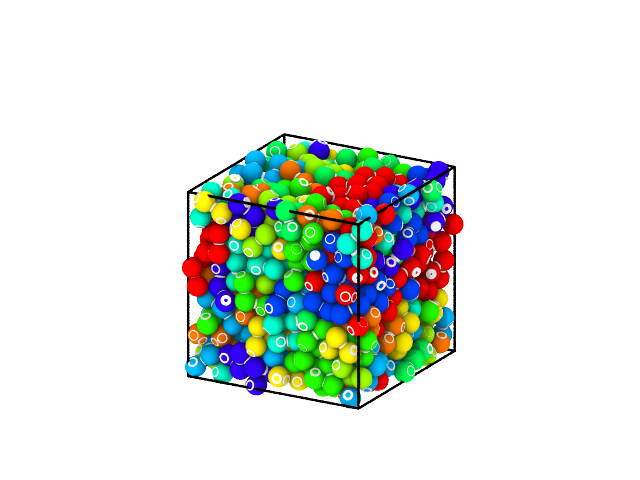